# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction import text

#words to keep: no couldnt cry not cant cannot nor except nobody off but serious enough nothing alone down only without


data = pd.read_json('./data/data.jsonl', lines=True)
original_data = data.copy() # never lemmatized

#remove stop words
my_stop_words = text.ENGLISH_STOP_WORDS
#print(my_stop_words)
words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without','hereby'])
my_stop_words = my_stop_words - words_to_keep

def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)
    
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in my_stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    return dataset

data = pre_process_data(data)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcarv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcarv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, s, job, position, succeed, just,...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, but, really, feel, ...",1
3,"[feeling, little, low, day]",0
4,"[beleive, sensitive, people, feeling, tend, co...",2


In [29]:
test_data = pd.read_json('./data/test5.jsonl', lines=True)
train_data = pd.read_json('./data/train3.jsonl', lines=True)
validation_data = pd.read_json('./data/validation5.jsonl', lines=True)



# remove duplicates
test_data = test_data.drop_duplicates(subset=['text'])
train_data = train_data.drop_duplicates(subset=['text'])
validation_data = validation_data.drop_duplicates(subset=['text'])

original_test_data = test_data.copy()
original_test_data['text'] = original_test_data['text'].apply(nltk.word_tokenize)
original_train_data = train_data.copy()
original_train_data['text'] = original_train_data['text'].apply(nltk.word_tokenize)
original_validation_data = validation_data.copy()
original_validation_data['text'] = original_validation_data['text'].apply(nltk.word_tokenize)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)
print(test_data['text'][13])

print(test_data["text"])

['woke', 'feeling', 'particularly', 'vile', 'tried', 'ignore', 'but', 'got', 'worse', 'worse', 'worse']
0       [feel, awful, s, job, position, succeed, just,...
1                                [im, alone, feel, awful]
2       [ive, probably, mentioned, but, really, feel, ...
3                             [feeling, little, low, day]
4       [beleive, sensitive, people, feeling, tend, co...
                              ...                        
5395              [feel, grumpy, haven, t, yoga, ed, day]
5396    [read, blog, suburb, direction, mentioned, cas...
5397    [not, feel, thing, realize, violent, physical,...
5398    [feel, petty, silly, giving, shit, but, little...
5399    [remember, feeling, bitter, couldnt, pop, ball...
Name: text, Length: 5396, dtype: object


# 2. Vectorization
(secção possívelmente temporária, mas queria experimentar as cenas de tf_idf depois do pré-processamento) -- matos
não acho que convenha ser temporaria, dado que efetivamente melhora os resultados ihihihi, e é uma prática comum e recomendada pelo que estivemos a ver -- ines


### TF-IDF

#### Hypertunning for tf-idf

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer




def tfidfVectorizer(data, train_data, validation_data, test_data):
    vectorizer = TfidfVectorizer(stop_words=list(my_stop_words), ngram_range=(1,2), max_features=40000)
    # good idea to use two-grams??
    # print(X.shape)

    x_train = vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



### BOW model
Count vectorizer which is an implementation of the BOW model.

The disadvantage of the BOW model is it does not consider the sequence of words, and as language does involve sequence and context, sometimes the BOW model might not be a good fit for the best-case scenario.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(data, train_data, validation_data, test_data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=40000)

    x_train= vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Doc 2 Vec

### Hypertunning doc2vec

In [5]:
# import optuna
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# import numpy as np

# y_train = train_data['label']
# y_val = validation_data['label']

# def objective(trial):
#     vector_size = trial.suggest_int("vector_size", 50, 300)
#     window = trial.suggest_int("window", 3, 15)
#     min_count = trial.suggest_int("min_count", 1, 10)
#     epochs = trial.suggest_int("epochs", 10, 50)
    
#     # Train Doc2Vec model
#     tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]
#     doc2vec_model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
#     doc2vec_model.build_vocab(tagged_data)
#     doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    
#     # Prepare document vectors for training and test sets
#     X_train_vecs  = [doc2vec_model.infer_vector(doc) for doc in train_data['text']]
#     X_val_vecs = [doc2vec_model.infer_vector(doc) for doc in validation_data['text']]
    
#     # Train Logistic Regression classifier
#     classifier = LogisticRegression(max_iter=1000)
#     classifier.fit(X_train_vecs, y_train)
    
#     # Evaluate on test set
#     y_pred = classifier.predict(X_val_vecs)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Define the study object and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters found
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# # Train the final model with the best hyperparameters
# best_vector_size = best_params["vector_size"]
# best_window = best_params["window"]
# best_min_count = best_params["min_count"]
# best_epochs = best_params["epochs"]

# # Train Doc2Vec model with best hyperparameters
# tagged_data = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(train_data["text"])]
# best_doc2vec_model = Doc2Vec(vector_size=best_vector_size, window=best_window, min_count=best_min_count, epochs=best_epochs)
# best_doc2vec_model.build_vocab(tagged_data)
# best_doc2vec_model.train(tagged_data, total_examples=best_doc2vec_model.corpus_count, epochs=best_doc2vec_model.epochs)

# # Prepare document vectors for training and test sets with the best Doc2Vec model
# X_train_vecs  = [best_doc2vec_model.infer_vector(doc) for doc in train_data['text']]
# X_val_vecs = [best_doc2vec_model.infer_vector(doc) for doc in validation_data['text']]

# # Train Logistic Regression classifier on the final Doc2Vec vectors
# final_classifier = LogisticRegression(max_iter=1000)
# final_classifier.fit(X_train_vecs, y_train)

# # Evaluate on test set
# final_accuracy = final_classifier.score(X_val_vecs, y_val)
# print("Final accuracy on test set with the best model:", final_accuracy)


In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils

def train_doc2vec(train_data):
    max_epochs = 16
    vec_size = 88
    alpha = 0.025
    window = 4
    min_count = 7

    tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]

    # antes tinha workers definidos
    model = Doc2Vec(vector_size=vec_size, window=window, min_count=min_count, epochs=max_epochs)
    
    model.build_vocab(tagged_data)


    model.train(tagged_data, total_examples=model.corpus_count, epochs=50)

    model.save("d2v_best_stopwords.model")
    print("Model Saved")

    return model

#train_doc2vec(train_data)

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec
from sklearn.decomposition import PCA

def doc2vec(data, train_data, validation_data, test_data):

    # training the doc2vec model
    #model = train_doc2vec(train_data)
    model = Doc2Vec.load("d2v_best_stopwords.model")
    
    x_train = [model.infer_vector(doc) for doc in train_data['text']]
    x_val = [model.infer_vector(doc) for doc in validation_data['text']]
    x_test = [model.infer_vector(doc) for doc in test_data['text']]

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Word embeddings using pre-trained models from twitter

In [8]:
from gensim.models import Word2Vec
import numpy as np
import gensim.downloader as api


def text_to_vector(embeddings, text, sequence_len):
    
    # split text into tokens
    tokens = text.split()
    
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:   # while there are tokens and did not reach desired sequence length
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # add blanks up to sequence_len, if needed
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    
    return vec

def text_to_mean_vector(embeddings, text):
     # split text into tokens
    tokens = text.split()

    # convert tokens to embedding vectors, up to sequence_len tokens
    total_vector = []
    i = 0
    while i < len(tokens):   # while there are tokens and did not reach desired sequence length
        try:
            total_vector.append(embeddings.get_vector(tokens[i]))
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1

    return np.mean(total_vector, axis=0)

def documents_to_vectors(embeddings, documents, sequence_len):
    vectors = []
    for doc in documents:
        vectors.append(text_to_vector(embeddings, doc, sequence_len))
    return np.array(vectors)


def documents_to_mean_vectors(embeddings, documents):
    vectors = []
    for doc in documents:
        vectors.append(text_to_mean_vector(embeddings, doc))
    return np.array(vectors)

def wordEmbeddingsVectorizer(data):
    
    # use twitter word embeddings
    model_glove_twitter = api.load("glove-twitter-25")
    
    # Initialize Word2Vec
    
    train = train_data['text'].apply(lambda x: ' '.join(x))
    val = validation_data['text'].apply(lambda x: ' '.join(x))
    test = test_data['text'].apply(lambda x: ' '.join(x))
    
    x_train = documents_to_vectors(model_glove_twitter, train, 40)
    x_val = documents_to_vectors(model_glove_twitter, val, 40)
    x_test = documents_to_vectors(model_glove_twitter, test, 40)
    
    print(x_train.shape, x_val.shape, x_test.shape)
    print(x_train[0])
    
    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test


def wordEmbeddingsMeanVectorizer(train_data, validation_data, test_data):

    # use twitter word embeddings
    model_glove_twitter = api.load("glove-twitter-25")

    # Initialize Word2Vec

    train = train_data['text'].apply(lambda x: ' '.join(x))
    val = validation_data['text'].apply(lambda x: ' '.join(x))
    test = test_data['text'].apply(lambda x: ' '.join(x))

    x_train = documents_to_mean_vectors(model_glove_twitter, train)
    x_val = documents_to_mean_vectors(model_glove_twitter, val)
    x_test = documents_to_mean_vectors(model_glove_twitter, test)

    # x_train = np.mean(x_train, axis=1)
    # x_val = np.mean(x_val, axis=1)
    # x_test = np.mean(x_test, axis=1)
    #
    print(x_train.shape, x_val.shape, x_test.shape)
    print(x_train[0])

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test


### Word2Vec - Word embeddings using gensim model 

### Hypertunne the word 2 vec model

In [9]:
# from gensim.models import Word2Vec
# import numpy as np
# import optuna
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC

# # Calculate mean for each dimension
# def calculate_mean_vectors(model, data):
#     vectors = []
#     for doc in data['text']:
#         document = []
#         for word in doc:
#             if word in model.wv:
#                 document.append(model.wv[word])
#         if document:
#             vectors.append(np.mean(document, axis=0))
#         else:
#             vectors.append(np.zeros(model.vector_size))
#     return np.array(vectors)

# def word_embeddings_vectorizer(train_data, validation_data, test_data, vector_size, window, min_count, sg):
#     data_model = Word2Vec(train_data["text"], vector_size=vector_size, window=window, min_count=min_count, sg=sg)
    
#     x_train = calculate_mean_vectors(data_model, train_data)
#     x_val = calculate_mean_vectors(data_model, validation_data)
#     x_test = calculate_mean_vectors(data_model, test_data)

#     y_train = train_data['label']
#     y_val = validation_data['label']
#     y_test = test_data['label']

#     return x_train, x_val, x_test, y_train, y_val, y_test


# def objective(trial):
#     # Define the search space for hyperparameters
#     vector_size = trial.suggest_int('vector_size', 50, 300)
#     window = trial.suggest_int('window', 2, 10)
#     min_count = trial.suggest_int('min_count', 1, 5)
#     sg = trial.suggest_categorical('sg', [0, 1])
    
#     # Call the function with the suggested hyperparameters
#     x_train, x_val, x_test, y_train, y_val, y_test = word_embeddings_vectorizer(train_data, validation_data, test_data, vector_size, window, min_count, sg)
    
#     # Train an SVC classifier
#     svc = SVC()
#     svc.fit(x_train, y_train)
    
#     # Predict on the validation set
#     y_pred = svc.predict(x_val)
    
#     # Calculate F1 score
#     f1 = f1_score(y_val, y_pred, average='weighted')  # Use weighted average for multiclass classification
    
#     return f1


# # Define your train_data, validation_data, and test_data here
# if __name__ == "__main__":
#     study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
#     study.optimize(objective, n_trials=100)  # You can adjust the number of trials as needed

#     print('Number of finished trials:', len(study.trials))
#     print('Best trial:', study.best_trial.params)
#     print('Best f1:', study.best_value)


In [10]:
from gensim.models import Word2Vec
import numpy as np

## calcular media a cada dimensão
def my_word2vec_model(model, data):
    vectors = []
    for doc in data['text']:
        document = []
        for word in doc:
            if word in model.wv:
                document.append(model.wv[word])
        if document:  # Check if the document is not empty
            vectors.append(np.mean(document, axis=0))  # Take the mean of word vectors for each document
        else:
            # If the document is empty, append a zero vector
            vectors.append(np.zeros(model.vector_size))
    
    return np.array(vectors)


def wordEmbeddingsVectorizer_Trained(train_data,  validation_data, test_data):

    # Hypertunning 1: 'vector_size': 120, 'window': 7, 'min_count': 3, 'sg': 1
    data_model = Word2Vec(train_data["text"], vector_size=88, window=10, min_count=2, workers=10, sg=1)
    
    x_train = my_word2vec_model(data_model, train_data)
    x_val = my_word2vec_model(data_model, validation_data)
    x_test = my_word2vec_model(data_model, test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Lexicons

In [11]:
from nrclex import NRCLex
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

lexicon_emotions = ['fear','anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'anticipation']

def get_features(data):
    features = []
    for text in data['text']:
        text = ' '.join(text)
        text = NRCLex(text)
        features.append([text.affect_frequencies.get(emotion, 0) for emotion in lexicon_emotions])
    return features

# text_object = NRCLex(text='I am nervous')
# print(text_object.affect_frequencies)
# print(text_object.affect_dict)
# print(text_object.top_emotions)
# print(text_object.affect_list)
# print(text_object.raw_emotion_scores)
# print(text_object.lexicon)


def lexiconVectorizer(train_data, validation_data, test_data):
    x_train = get_features(train_data)
    x_val = get_features(validation_data)
    x_test = get_features(test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Choosing algorithm

In [37]:
# Choose vectorizer (featurizer)
x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsMeanVectorizer(train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer_Trained(train_data, validation_data, test_data)
# x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)


In [30]:
# join the features
# import numpy as np

# Using with lexicon 
x_train_lexicon, x_val_lexicon, x_test_lexicon, y_train_lexicon, y_val_lexicon, y_test_lexicon = lexiconVectorizer(original_train_data, original_validation_data, original_test_data)


In [36]:
# join the features
# x_train_lexicon2 = np.array(x_train_lexicon)
# print(x_train_lexicon2.shape)
# x_train2 = np.concatenate((x_train, x_train_lexicon), axis=1)
# x_val2 = np.hstack((x_val.toarray(), x_val_lexicon))
# x_test2 = np.hstack((x_test.toarray(), x_test_lexicon))


(42607, 11)


ValueError: zero-dimensional arrays cannot be concatenated

In [18]:
print(x_train.shape)
print(x_train_lexicon[:3])
print(x_train[:3])

(42607, 40000)
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0], [0.15384615384615385, 0.07692307692307693, 0.0, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.15384615384615385, 0.15384615384615385, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693], [0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.4, 0.2, 0.2, 0.0, 0]]
  (0, 32595)	0.44382415483477683
  (0, 9534)	0.5180883291594622
  (0, 17720)	0.7248221208380449
  (0, 10609)	0.09611189269695694
  (1, 12131)	0.5456063331751863
  (1, 33361)	0.5444785796625673
  (1, 16005)	0.43594965484883114
  (1, 11801)	0.15183366990167263
  (1, 33353)	0.4390344412561912
  (2, 11161)	0.5270701621378975
  (2, 31956)	0.42658852580279044
  (2, 18561)	0.6010116053088199
  (2, 18174)	0.41386721188137643
  (2, 10609)	0.08785360010257795


### Apply SMOTE

In [ ]:
## Apply SMOTE
import numpy as np
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=4, sampling_strategy='auto', k_neighbors=18)
x_train, y_train = smote.fit_resample(x_train, y_train)

#### Hypertunning number of features (using PCA) for each model

In [ ]:
# import optuna
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC
# import lightgbm as lgb

# def objective(trial):
#     # Define parameters to search
#     n_components = trial.suggest_int('n_components', 2, 25)
    
#     # Define the pipeline with PCA and a classifier
#     pipeline = Pipeline([
#         ('pca', PCA(n_components=n_components)),
#         #('clf', SVC())
#         ('clf', lgb.LGBMClassifier())
#         #('clf', LogisticRegression())
#     ])

#     # Fit the pipeline
#     pipeline.fit(x_train, y_train)
    
#     # Evaluate on the validation set
#     y_pred = pipeline.predict(x_val)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Optimize hyperparameters
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters found
# best_params = study.best_params

# # Get the best model
# best_n_components = best_params['n_components']
# best_model = Pipeline([
#     ('pca', PCA(n_components=best_n_components)),
#     ('clf', )  
# ])
# best_model.fit(x_train, y_train)

# # Use the best model for prediction
# y_pred = best_model.predict(x_test)

# # Evaluate the best model
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)



# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

##### Model hypertunning

In [ ]:
# import optuna
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# # Define objective function for Optuna
# def objective(trial):
#     # Define solver
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
#     if solver == 'lbfgs':
#         penalty = 'l2'  # LBFGS only supports L2 penalty
#     else:
#         penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
#     C = trial.suggest_loguniform('C', 0.01, 10)
    
#     # Instantiate Logistic Regression classifier with hyperparameters
#     logreg_classifier = LogisticRegression(max_iter=1000, solver=solver, penalty=penalty, C=C)
    
#     # Train classifier
#     logreg_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = logreg_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

##### Model Training

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# pca = PCA(n_components=77)
# x_train = pca.fit_transform(x_train)
# x_val = pca.transform(x_val)
# x_test = pca.transform(x_test)

logreg_classifier = LogisticRegression(solver='liblinear', penalty='l2', C=0.03784347512520397)
logreg_classifier.fit(x_train, y_train)

0.8996103173130451
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       902
           1       0.92      0.81      0.87       865
           2       0.86      0.98      0.92       904
           3       0.91      0.90      0.90       881
           4       0.92      0.82      0.86       931
           5       0.89      0.99      0.93       906

    accuracy                           0.90      5389
   macro avg       0.90      0.90      0.90      5389
weighted avg       0.90      0.90      0.90      5389

[[805  16  20  30  25   6]
 [ 19 704  92  20  13  17]
 [  5   5 887   3   2   2]
 [ 17  23  11 794  29   7]
 [ 32   9  15  30 762  83]
 [  0   5   4   0   1 896]]


In [66]:
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.885
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1566
           1       0.96      0.83      0.89      1836
           2       0.68      0.97      0.80       432
           3       0.86      0.90      0.88       756
           4       0.84      0.90      0.87       594
           5       0.79      0.97      0.87       216

    accuracy                           0.89      5400
   macro avg       0.84      0.91      0.87      5400
weighted avg       0.90      0.89      0.89      5400

[[1410   32   33   46   35   10]
 [  54 1525  151   41   37   28]
 [   3    2  420    3    3    1]
 [  20   20    6  680   23    7]
 [  16    8    9   15  535   11]
 [   0    4    0    2    1  209]]


## SVM


##### Hypertunning

In [ ]:
# import optuna
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# def objective(trial):
#     # Define kernel
#     kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    
#     # For 'poly', 'rbf', and 'sigmoid' kernels, suggest degree parameter
#     if kernel in ['poly', 'rbf', 'sigmoid']:
#         degree = trial.suggest_int('degree', 2, 5)
#     else:
#         degree = 3  # Default degree value for kernels that don't use it
    
#     # Instantiate SVM classifier with hyperparameters
#     svm_classifier = SVC(kernel=kernel, degree=degree)
    
#     # Train classifier
#     svm_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = svm_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

# #[I 2024-04-01 12:39:28,014] Trial 36 finished with value: 0.8245 and parameters: {'kernel': 'poly', 'degree': 2}. Best is trial 36 with value: 0.8245.


### Training

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_classifier = SVC(kernel='poly', degree=2, random_state=42)
svm_classifier.fit(x_train, y_train)

Accuracy: 0.8996103173130451
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       902
           1       0.89      0.87      0.88       865
           2       0.89      0.95      0.92       904
           3       0.92      0.91      0.91       881
           4       0.88      0.84      0.86       931
           5       0.90      0.93      0.92       906

    accuracy                           0.90      5389
   macro avg       0.90      0.90      0.90      5389
weighted avg       0.90      0.90      0.90      5389

Confusion Matrix:
 [[817  24   7  31  20   3]
 [ 12 751  79   5   8  10]
 [  6  30 858   5   4   1]
 [ 25  16   4 799  35   2]
 [ 26  15   5  29 778  78]
 [  2  12   7   2  38 845]]


In [67]:
y_pred = svm_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.919074074074074
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1566
           1       0.95      0.90      0.93      1836
           2       0.76      0.97      0.85       432
           3       0.91      0.91      0.91       756
           4       0.90      0.92      0.91       594
           5       0.88      0.96      0.92       216

    accuracy                           0.92      5400
   macro avg       0.89      0.93      0.91      5400
weighted avg       0.92      0.92      0.92      5400

Confusion Matrix:
 [[1449   38   14   40   21    4]
 [  31 1655  117   11   11   11]
 [   5    5  421    1    0    0]
 [  18   24    1  685   25    3]
 [  12   10    2   15  546    9]
 [   3    3    0    2    1  207]]


## KNN

##### Hypertunning

In [ ]:
# import optuna
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
#     algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    
#     # Instantiate KNN classifier with hyperparameters
#     knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    
#     # Train classifier
#     knn_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = knn_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

# # [I 2024-04-01 13:53:46,403] Trial 26 finished with value: 0.701 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 26 with value: 0.701.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

#knn_classifier = KNeighborsClassifier(n_neighbors=5)
hyperparameters = {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}
knn_classifier = KNeighborsClassifier(**hyperparameters)
knn_classifier.fit(x_train, y_train)

Accuracy: 0.7478196325848951
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.77       902
           1       0.82      0.69      0.75       865
           2       0.84      0.76      0.79       904
           3       0.55      0.89      0.68       881
           4       0.77      0.70      0.73       931
           5       0.86      0.73      0.79       906

    accuracy                           0.75      5389
   macro avg       0.78      0.75      0.75      5389
weighted avg       0.78      0.75      0.75      5389

Confusion Matrix:
 [[654  20  27 150  42   9]
 [ 31 594  66 117  37  20]
 [ 31  49 684 110  21   9]
 [ 27  18  10 785  37   4]
 [ 34  17  13 148 653  66]
 [ 22  25  19 118  62 660]]


In [68]:
y_pred = knn_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7511111111111111
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1566
           1       0.93      0.70      0.80      1836
           2       0.63      0.75      0.69       432
           3       0.50      0.88      0.64       756
           4       0.71      0.77      0.74       594
           5       0.66      0.70      0.68       216

    accuracy                           0.75      5400
   macro avg       0.72      0.76      0.73      5400
weighted avg       0.80      0.75      0.76      5400

Confusion Matrix:
 [[1173   38   45  229   65   16]
 [  67 1283  120  266   61   39]
 [  18   21  323   55   11    4]
 [  22   15   11  665   34    9]
 [  19   11    8   85  460   11]
 [   8    9    4   28   15  152]]


### Boosting Algorithms

Testing with some boosting algorithms

##### XGBOOST

In [24]:
import xgboost as xgb
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train, y_train)

XGBoost Classifier Evaluation:
Accuracy: 0.9155687511597699
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       902
           1       0.93      0.87      0.90       865
           2       0.90      0.98      0.94       904
           3       0.91      0.92      0.92       881
           4       0.90      0.86      0.88       931
           5       0.89      0.98      0.94       906

    accuracy                           0.92      5389
   macro avg       0.92      0.92      0.92      5389
weighted avg       0.92      0.92      0.92      5389

Confusion Matrix:
 [[792  27  12  38  26   7]
 [  7 753  76  10   4  15]
 [  1   8 888   1   2   4]
 [ 12   8   5 810  41   5]
 [ 12   9   6  27 800  77]
 [  0   1   3   0  11 891]]


In [69]:
y_pred = xgb_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      1566
           1       0.96      0.88      0.92      1836
           2       0.74      0.99      0.85       432
           3       0.87      0.92      0.90       756
           4       0.87      0.94      0.91       594
           5       0.80      0.99      0.88       216

    accuracy                           0.91      5400
   macro avg       0.87      0.94      0.90      5400
weighted avg       0.92      0.91      0.91      5400

Confusion Matrix:
 [[1394   50   19   57   35   11]
 [  20 1623  125   27   13   28]
 [   0    2  426    1    2    1]
 [   9    9    5  699   29    5]
 [   7    4    1   14  558   10]
 [   0    0    0    1    1  214]]


##### Lightgbm

In [25]:
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(x_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100080
[LightGBM] [Info] Number of data points in the train set: 43117, number of used features: 3165
[LightGBM] [Info] Start training from score -1.791783
[LightGBM] [Info] Start training from score -1.797505
[LightGBM] [Info] Start training from score -1.779611
[LightGBM] [Info] Start training from score -1.788171
[LightGBM] [Info] Start training from score -1.801572
[LightGBM] [Info] Start training from score -1.792061

LightGBM Classifier Evaluation:
Accuracy: 0.917238819818148
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       902
           1       0.94      0.88      0.90       865
           2       0.90      0.97      0.94       904
           3     

In [70]:
y_pred_lgb = lgb_classifier.predict(x_val)

# Evaluate the performance for LightGBM
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
report_lgb = classification_report(y_val, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_val, y_pred_lgb)

# Print the evaluation metrics for LightGBM
print("\nLightGBM Classifier Evaluation:")
print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", report_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)


LightGBM Classifier Evaluation:
Accuracy: 0.9174074074074074
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      1566
           1       0.96      0.89      0.92      1836
           2       0.76      0.97      0.85       432
           3       0.89      0.93      0.91       756
           4       0.89      0.96      0.92       594
           5       0.83      0.98      0.90       216

    accuracy                           0.92      5400
   macro avg       0.88      0.94      0.91      5400
weighted avg       0.92      0.92      0.92      5400

Confusion Matrix:
 [[1419   46   16   49   28    8]
 [  26 1631  116   27   10   26]
 [   3    8  420    1    0    0]
 [  10   10    3  703   28    2]
 [   7    2    0    8  569    8]
 [   0    0    0    2    2  212]]


In [26]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(x_train, y_train)


AdaBoost Classifier Evaluation:
Accuracy: 0.3015401744293932
Classification Report:
               precision    recall  f1-score   support

           0       0.02      0.00      0.00       902
           1       0.00      0.00      0.00       865
           2       0.21      0.99      0.34       904
           3       0.00      0.00      0.00       881
           4       0.20      0.03      0.05       931
           5       0.88      0.78      0.82       906

    accuracy                           0.30      5389
   macro avg       0.22      0.30      0.20      5389
weighted avg       0.22      0.30      0.20      5389

Confusion Matrix:
 [[  1   0 894   0   0   7]
 [  0   0 850   0   0  15]
 [  0   0 896   0   1   7]
 [  0   0 872   0   1   8]
 [  0   0 843   0  25  63]
 [ 58   8   4  37  96 703]]


In [71]:
y_pred_adaboost = adaboost_classifier.predict(x_val)

# Evaluate the performance for AdaBoost
accuracy_adaboost = accuracy_score(y_val, y_pred_adaboost)
report_adaboost = classification_report(y_val, y_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_val, y_pred_adaboost)

# Print the evaluation metrics for AdaBoost
print("AdaBoost Classifier Evaluation:")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:\n", report_adaboost)
print("Confusion Matrix:\n", conf_matrix_adaboost)


AdaBoost Classifier Evaluation:
Accuracy: 0.11259259259259259
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1566
           1       0.00      0.00      0.00      1836
           2       0.08      1.00      0.16       432
           3       0.00      0.00      0.00       756
           4       0.12      0.01      0.01       594
           5       0.72      0.81      0.76       216

    accuracy                           0.11      5400
   macro avg       0.15      0.30      0.15      5400
weighted avg       0.05      0.11      0.04      5400

Confusion Matrix:
 [[   0    0 1553    0    0   13]
 [   0    0 1804    0    3   29]
 [   0    0  431    0    0    1]
 [   0    0  748    0    0    8]
 [   0    0  575    0    3   16]
 [  16    1    0    5   20  174]]


### Naive Bayes

### Hypertuning

In [62]:
# import optuna
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split
# 
# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
# 
#     
#     # Instantiate Naive Bayes classifier with hyperparameters
#     mnb_classifier = MultinomialNB(alpha=alpha)
# 
#     
#     # Train classifier
#     mnb_classifier.fit(x_train, y_train)
#     
#     # Predict on validation set
#     y_pred = mnb_classifier.predict(x_val)
#     
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
#     
#     return accuracy
# 
# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# 
# # Get best hyperparameters
# best_params = study.best_params
# 
# print(best_params)


[I 2024-04-03 22:15:43,209] A new study created in memory with name: no-name-01cfcdeb-373c-434b-954d-d263f6e58a1b
C:\Users\jcarv\AppData\Local\Temp\ipykernel_57496\3324414873.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
[I 2024-04-03 22:15:43,236] Trial 0 finished with value: 0.7600668027463351 and parameters: {'alpha': 0.0013964537506036552}. Best is trial 0 with value: 0.7600668027463351.
C:\Users\jcarv\AppData\Local\Temp\ipykernel_57496\3324414873.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
[I 2024-04-03 22:15:43,263] Trial 1 finished with value:

{'alpha': 0.09965020089826075}


In [63]:
from sklearn.naive_bayes import MultinomialNB

hyperparameters = {'alpha': 0.09965020089826075}
mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train, y_train)
y_pred_mnb = mnb_classifier.predict(x_val)

# Evaluate the performance for Multinomial Naive Bayes
accuracy_mnb = accuracy_score(y_val, y_pred_mnb)
report_mnb = classification_report(y_val, y_pred_mnb)
conf_matrix_mnb = confusion_matrix(y_val, y_pred_mnb)

# Print the evaluation metrics for Multinomial Naive Bayes
print("Multinomial Naive Bayes Classifier Evaluation:")
print("Accuracy:", accuracy_mnb)
print("Classification Report:\n", report_mnb)

Multinomial Naive Bayes Classifier Evaluation:
Accuracy: 0.8942289849693821
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       902
           1       0.92      0.82      0.87       865
           2       0.86      0.96      0.90       904
           3       0.91      0.91      0.91       881
           4       0.89      0.85      0.87       931
           5       0.87      0.94      0.90       906

    accuracy                           0.89      5389
   macro avg       0.90      0.89      0.89      5389
weighted avg       0.90      0.89      0.89      5389


In [72]:
y_pred_mnb = mnb_classifier.predict(x_val)

# Evaluate the performance for Multinomial Naive Bayes
accuracy_mnb = accuracy_score(y_val, y_pred_mnb)
report_mnb = classification_report(y_val, y_pred_mnb)
conf_matrix_mnb = confusion_matrix(y_val, y_pred_mnb)

# Print the evaluation metrics for Multinomial Naive Bayes
print("Multinomial Naive Bayes Classifier Evaluation:")
print("Accuracy:", accuracy_mnb)
print("Classification Report:\n", report_mnb)

Multinomial Naive Bayes Classifier Evaluation:
Accuracy: 0.8944444444444445
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      1566
           1       0.97      0.85      0.91      1836
           2       0.69      0.97      0.81       432
           3       0.87      0.90      0.89       756
           4       0.87      0.93      0.90       594
           5       0.71      0.96      0.81       216

    accuracy                           0.89      5400
   macro avg       0.84      0.92      0.87      5400
weighted avg       0.91      0.89      0.90      5400


In [37]:
# não dá com tfidf por ser esparso
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(x_train, y_train)



TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [ ]:
y_pred_gnb = gnb_classifier.predict(x_val)

# Evaluate the performance for Gaussian Naive Bayes
accuracy_gnb = accuracy_score(y_val, y_pred_gnb)
report_gnb = classification_report(y_val, y_pred_gnb)
conf_matrix_gnb = confusion_matrix(y_val, y_pred_gnb)

# Print the evaluation metrics for Gaussian Naive Bayes
print("Gaussian Naive Bayes Classifier Evaluation:")
print("Accuracy:", accuracy_gnb)
print("Classification Report:\n", report_gnb)
print("Confusion Matrix:\n", conf_matrix_gnb)

### Random Forest

##### Hypertunning

In [ ]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Define the objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000)
#     max_depth = trial.suggest_int('max_depth', 10, 100)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    
#     # Instantiate Random Forest classifier with hyperparameters
#     rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

#     # Train classifier
#     rf_classifier.fit(x_train, y_train)

#     # Predict on validation set
#     y_pred = rf_classifier.predict(x_val)
        
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)

#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

In [38]:
from sklearn.ensemble import RandomForestClassifier

# hyperparameters = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}  # placeholders
# rf_classifier = RandomForestClassifier(**hyperparameters)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)


Random Forest Classifier Evaluation:
Accuracy: 0.9062905919465578
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       902
           1       0.93      0.86      0.89       865
           2       0.89      0.97      0.93       904
           3       0.91      0.92      0.92       881
           4       0.87      0.86      0.87       931
           5       0.89      0.94      0.91       906

    accuracy                           0.91      5389
   macro avg       0.91      0.91      0.91      5389
weighted avg       0.91      0.91      0.91      5389

Confusion Matrix:
 [[805  13  14  37  25   8]
 [ 11 741  83   9   7  14]
 [  1  23 875   1   0   4]
 [ 18   7   6 811  36   3]
 [ 10   5   6  31 798  81]
 [  0   5   0   0  47 854]]


In [73]:
y_pred_rf = rf_classifier.predict(x_val)

# Evaluate the performance for Random Forest
accuracy_rf = accuracy_score(y_val, y_pred_rf)
report_rf = classification_report(y_val, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)

# Print the evaluation metrics for Random Forest
print("Random Forest Classifier Evaluation:")
print("Accuracy:", accuracy_rf)
print("Classification Report:\n", report_rf)
print("Confusion Matrix:\n", conf_matrix_rf)

Random Forest Classifier Evaluation:
Accuracy: 0.9124074074074074
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      1566
           1       0.98      0.87      0.92      1836
           2       0.73      0.98      0.84       432
           3       0.88      0.93      0.91       756
           4       0.88      0.95      0.91       594
           5       0.80      1.00      0.89       216

    accuracy                           0.91      5400
   macro avg       0.87      0.94      0.90      5400
weighted avg       0.92      0.91      0.91      5400

Confusion Matrix:
 [[1413   27   22   58   34   12]
 [  31 1605  131   24   17   28]
 [   0    3  425    2    1    1]
 [   9    7    3  706   27    4]
 [   7    1    3   12  563    8]
 [   0    0    0    1    0  215]]


### Neural Network - MLP

##### Hypertunning

In [ ]:
# import optuna
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score

# # Define the objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 1, 100)
#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    
#     # Instantiate MLP classifier with hyperparameters
#     mlp_classifier = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes,), activation=activation, solver=solver, alpha=alpha)

#     # Train classifier
#     mlp_classifier.fit(x_train, y_train)

#     # Predict on validation set
#     y_pred = mlp_classifier.predict(x_val)
        
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)

#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)


In [41]:
from sklearn.neural_network import MLPClassifier

# hyperparameters = {'hidden_layer_sizes': 100, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001} # placeholders
# mlp_classifier = MLPClassifier(**hyperparameters)
mlp_classifier = MLPClassifier()
mlp_classifier.fit(x_train, y_train)


Multilayer Perceptron Classifier Evaluation:
Accuracy: 0.8871775839673409
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       902
           1       0.88      0.86      0.87       865
           2       0.89      0.91      0.90       904
           3       0.92      0.90      0.91       881
           4       0.82      0.85      0.84       931
           5       0.90      0.88      0.89       906

    accuracy                           0.89      5389
   macro avg       0.89      0.89      0.89      5389
weighted avg       0.89      0.89      0.89      5389

Confusion Matrix:
 [[832   6   8  25  28   3]
 [ 12 741  77  10  11  14]
 [  3  67 825   4   4   1]
 [ 34   8   6 797  34   2]
 [ 27   5   2  34 793  70]
 [  0  11   4   1  97 793]]


In [74]:
y_pred_mlp = mlp_classifier.predict(x_val)

# Evaluate the performance for Multilayer Perceptron
accuracy_mlp = accuracy_score(y_val, y_pred_mlp)
report_mlp = classification_report(y_val, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_val, y_pred_mlp)

# Print the evaluation metrics for Multilayer Perceptron
print("Multilayer Perceptron Classifier Evaluation:")
print("Accuracy:", accuracy_mlp)
print("Classification Report:\n", report_mlp)
print("Confusion Matrix:\n", conf_matrix_mlp)


Multilayer Perceptron Classifier Evaluation:
Accuracy: 0.9138888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1566
           1       0.97      0.89      0.93      1836
           2       0.76      0.94      0.84       432
           3       0.89      0.92      0.90       756
           4       0.85      0.91      0.88       594
           5       0.87      0.91      0.89       216

    accuracy                           0.91      5400
   macro avg       0.88      0.92      0.90      5400
weighted avg       0.92      0.91      0.92      5400

Confusion Matrix:
 [[1461   15   11   39   36    4]
 [  33 1632  115   21   21   14]
 [   4   20  407    1    0    0]
 [  22    5    3  696   27    3]
 [  12    4    1   26  542    9]
 [   2    3    0    2   12  197]]


###  Bagging Algorithm

In [ ]:
# from sklearn.ensemble import BaggingClassifier, VotingClassifier

# model1 = xgb_classifier
# model2 = svm_classifier
# model3 = logreg_classifier

# voting_clf = VotingClassifier(estimators=[
#     ('model1', model1), 
#     ('model2', model2),
#     ('model3', model3)
# ], voting='soft')
# # Fit the ensemble model
# voting_clf.fit(x_train, y_train)

# # Predict the validation set
# y_pred_voting = voting_clf.predict(x_val)

# # Evaluate the performance for the ensemble model
# accuracy_voting = accuracy_score(y_val, y_pred_voting)
# report_voting = classification_report(y_val, y_pred_voting)
# conf_matrix_voting = confusion_matrix(y_val, y_pred_voting)

# # Print the evaluation metrics for the ensemble model
# print("Voting Classifier Evaluation:")
# print("Accuracy:", accuracy_voting)
# print("Classification Report:\n", report_voting)
# print("Confusion Matrix:\n", conf_matrix_voting)


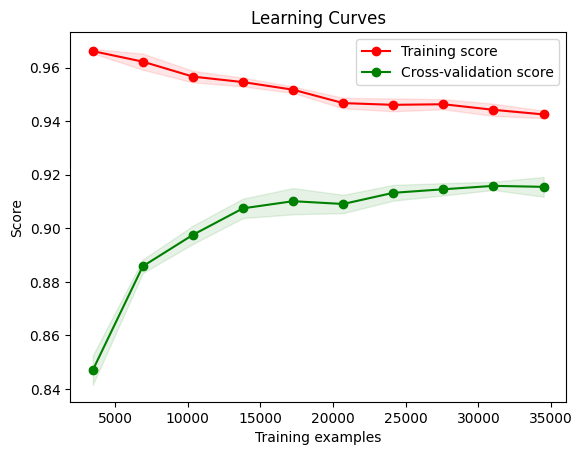

In [59]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X_train, y_train, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10),
        scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")

    plt.legend(loc="best")
    return plt


model = xgb.XGBClassifier()
plot_learning_curves(model, x_train, y_train, cv=5)
plt.show()

# 5. Model Evaluation

In [75]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_logreg = logreg_classifier.predict(x_test)

0.8855555555555555
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1566
           1       0.95      0.84      0.89      1836
           2       0.67      0.97      0.79       432
           3       0.87      0.90      0.88       756
           4       0.84      0.90      0.87       594
           5       0.79      1.00      0.88       216

    accuracy                           0.89      5400
   macro avg       0.85      0.92      0.87      5400
weighted avg       0.90      0.89      0.89      5400

[[1399   35   30   45   44   13]
 [  49 1536  157   43   32   19]
 [   1    4  419    3    2    3]
 [  11   22   15  677   26    5]
 [  14   11    9    8  536   16]
 [   0    1    0    0    0  215]]


In [76]:
y_pred = mnb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8964814814814814
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1566
           1       0.97      0.85      0.91      1836
           2       0.67      0.95      0.79       432
           3       0.89      0.92      0.90       756
           4       0.85      0.92      0.88       594
           5       0.74      0.95      0.83       216

    accuracy                           0.90      5400
   macro avg       0.85      0.92      0.87      5400
weighted avg       0.91      0.90      0.90      5400

[[1416   23   27   45   38   17]
 [  20 1567  159   31   27   32]
 [   2   13  412    2    2    1]
 [   9    4   14  696   25    8]
 [  15    4    4   12  545   14]
 [   1    5    1    0    4  205]]


In [77]:
y_pred = svm_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.9231481481481482
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1566
           1       0.96      0.91      0.93      1836
           2       0.75      0.97      0.85       432
           3       0.92      0.92      0.92       756
           4       0.89      0.91      0.90       594
           5       0.88      0.97      0.92       216

    accuracy                           0.92      5400
   macro avg       0.89      0.94      0.91      5400
weighted avg       0.93      0.92      0.92      5400

[[1450   36    7   41   27    5]
 [  24 1666  122    7    8    9]
 [   1    7  420    2    2    0]
 [  15   11    6  696   26    2]
 [  13    9    3   13  543   13]
 [   2    2    0    0    2  210]]


In [78]:
y_pred = xgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.9131481481481482
              precision    recall  f1-score   support

           0       0.98      0.90      0.93      1566
           1       0.97      0.89      0.93      1836
           2       0.74      0.98      0.84       432
           3       0.88      0.93      0.90       756
           4       0.87      0.93      0.90       594
           5       0.79      0.98      0.88       216

    accuracy                           0.91      5400
   macro avg       0.87      0.93      0.90      5400
weighted avg       0.92      0.91      0.91      5400

[[1402   44   15   55   37   13]
 [  21 1638  124   25   10   18]
 [   1    3  423    1    1    3]
 [   5    4    6  705   31    5]
 [   5    2    3   17  551   16]
 [   0    1    0    0    3  212]]


In [79]:
y_pred = lgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.917962962962963
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1566
           1       0.96      0.90      0.93      1836
           2       0.75      0.96      0.84       432
           3       0.89      0.94      0.91       756
           4       0.89      0.94      0.91       594
           5       0.81      0.98      0.88       216

    accuracy                           0.92      5400
   macro avg       0.88      0.94      0.90      5400
weighted avg       0.93      0.92      0.92      5400

[[1416   45   12   51   31   11]
 [  26 1645  118   23    8   16]
 [   0    9  416    3    2    2]
 [   6    5    3  710   26    6]
 [   4    1    3   11  559   16]
 [   0    1    1    0    3  211]]


In [80]:
y_pred = adaboost_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.11074074074074074
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1566
           1       0.00      0.00      0.00      1836
           2       0.08      0.99      0.15       432
           3       0.00      0.00      0.00       756
           4       0.21      0.01      0.02       594
           5       0.74      0.77      0.75       216

    accuracy                           0.11      5400
   macro avg       0.17      0.29      0.15      5400
weighted avg       0.06      0.11      0.04      5400

[[   0    0 1553    0    1   12]
 [   0    0 1816    0    0   20]
 [   0    0  427    0    0    5]
 [   0    0  747    0    2    7]
 [   0    1  574    0    5   14]
 [  20    0    0   14   16  166]]


In [81]:
y_pred = knn_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7433333333333333
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1566
           1       0.93      0.68      0.78      1836
           2       0.63      0.69      0.66       432
           3       0.48      0.89      0.62       756
           4       0.71      0.78      0.74       594
           5       0.70      0.81      0.75       216

    accuracy                           0.74      5400
   macro avg       0.73      0.76      0.73      5400
weighted avg       0.80      0.74      0.75      5400

[[1161   44   29  258   62   12]
 [  59 1246  123  294   80   34]
 [  14   26  297   76   15    4]
 [  19   16   16  674   21   10]
 [  21    6    5   85  462   15]
 [   6    5    3   21    7  174]]


In [82]:
y_pred = rf_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9175925925925926
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1566
           1       0.98      0.89      0.93      1836
           2       0.73      0.99      0.84       432
           3       0.89      0.95      0.92       756
           4       0.88      0.93      0.90       594
           5       0.81      0.99      0.89       216

    accuracy                           0.92      5400
   macro avg       0.88      0.94      0.90      5400
weighted avg       0.93      0.92      0.92      5400

[[1414   26   21   52   42   11]
 [  24 1635  131   20   11   15]
 [   0    2  427    0    0    3]
 [   4    7    5  715   21    4]
 [   6    4    3   13  551   17]
 [   0    1    1    0    1  213]]


In [83]:
y_pred = mlp_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9101851851851852
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1566
           1       0.97      0.87      0.92      1836
           2       0.74      0.94      0.83       432
           3       0.90      0.94      0.92       756
           4       0.85      0.90      0.87       594
           5       0.81      0.92      0.86       216

    accuracy                           0.91      5400
   macro avg       0.87      0.92      0.89      5400
weighted avg       0.92      0.91      0.91      5400

[[1460   18    5   36   44    3]
 [  38 1605  129   22   19   23]
 [   2   17  408    1    3    1]
 [  16    5    2  707   21    5]
 [  18    6    3   17  537   13]
 [   0    5    1    2   10  198]]


# 6. Cause of errors


In [50]:
emotions_to_int = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

int_to_emotions = {v: k for k, v in emotions_to_int.items()}


wrong_predictions = y_test[y_test != y_pred_logreg].index
for i, index in enumerate(wrong_predictions):
    if i == 10:
        break
    print(test_data['text'][index])
    print('Real: ', int_to_emotions[test_data['label'][index]])
    print('Pred:', int_to_emotions[y_pred_logreg[index]])
    print('\n')



['forget', 'just', 'want', 'feel', 'weird', 'work', 'far', 'hometown']
Real:  fear
Pred: surprise


['mean', 'he', 'just', 'sweet', 'bea', 'feel', 'like', 'totally', 'understands', 'but', 'hand', 'dangerous', 'he', 'vampire']
Real:  anger
Pred: love


['im', 'not', 'careful', 'easy', 'fall', 'feeling', 'overwhelmed', 'day']
Real:  fear
Pred: surprise


['didn', 't', 'enjoy', 'feel', 'extremely', 'unsure', 'lousy', 'alone', 'long', 'time']
Real:  fear
Pred: sadness


['closed', 'feeling', 'dissatisfied', 'im', 'curious', 'huntley', 'fitzpatrick', 'going']
Real:  anger
Pred: surprise


['feel', 'neurotic', 'talked', 'therapist', 'said', 'use', 'good', 'finding', 'headspace']
Real:  fear
Pred: joy


['not', 'wishing', 'november', 'away', 'trying', 'forget', 'thanksgiving', 'but', 'need', 'mindful', 'really', 'matter', 'feel', 'overwhelmed']
Real:  fear
Pred: surprise


['feel', 'like', 'im', 'petrified', 'care', 'case', 'take', 'away', 'family']
Real:  fear
Pred: love


['cant', 'remember

In [51]:
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

[[787  21  19  37  23   9]
 [ 19 730  85  18  19  12]
 [  5   7 889   7   9   3]
 [ 19  30  15 798  35   7]
 [ 26  16  12  19 729  83]
 [  1   8   3   3   4 885]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       896
           1       0.90      0.83      0.86       883
           2       0.87      0.97      0.92       920
           3       0.90      0.88      0.89       904
           4       0.89      0.82      0.86       885
           5       0.89      0.98      0.93       904

    accuracy                           0.89      5392
   macro avg       0.89      0.89      0.89      5392
weighted avg       0.89      0.89      0.89      5392


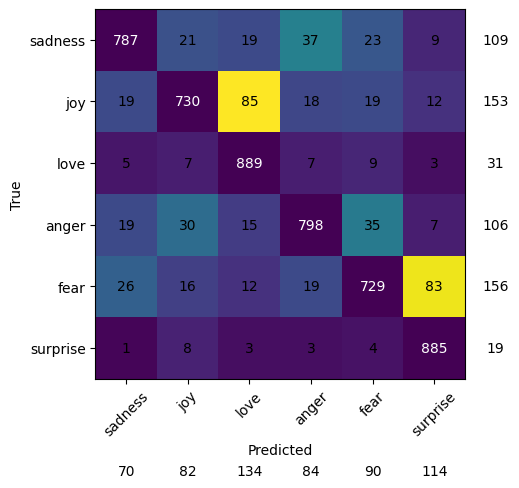

In [52]:
# check which emotions are being confused
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
    
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
# annotate the axes with the emotion names
plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
# add colorbar more to the right
# plt.colorbar()
# legend the axes with predicted and true values
plt.xlabel('Predicted')
plt.ylabel('True')

# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, conf_matrix_copy[i, j], ha='center', va='center', color='white')
        else:
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

for i in range(conf_matrix.shape[0]): # this does not count correct predictions
    plt.text(6, i, conf_matrix[i, :].sum(), ha='center', va='center', color='black')
for i in range(conf_matrix.shape[1]):
    plt.text(i, 7, conf_matrix[:, i].sum(), ha='center', va='center', color='black')
plt.show()

The test set appears to be unbalance.
- 'joy' is a lot more mixed with 'love' than the contrary. 
- 'surprise' has a low Precision

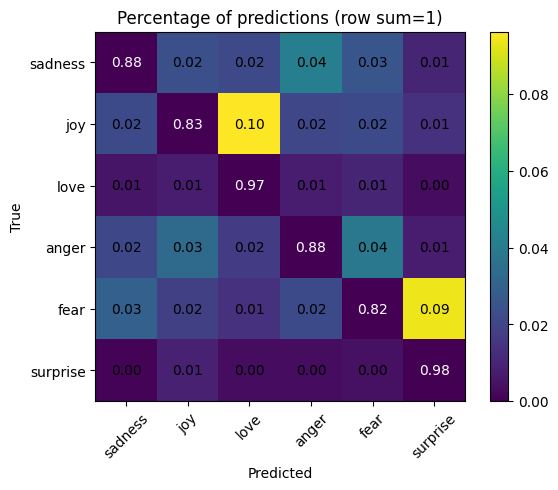

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, None] # normalize the confusion matrix
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')

plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, f'{conf_matrix_copy[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            plt.text(j, i, f'{conf_matrix[i, j]:.2f}', ha='center', va='center', color='black')

        
plt.title('Percentage of predictions (row sum=1)')
# Rows add to 1
plt.show()



- sadness mixed with joy and anger
- joy mixed with love
- love mixed with joy
- anger mixed with sadness and joy??
- fear mixed with sadness
- surprise mixed with almost everything

# 7. Experiment with user-inputed setences

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text

emotions = {
    0: "0. sadness",
    1: "1. joy",
    2: "2. love",
    3: "3. anger",
    4: "4. fear",
    5: "5. surprise"
}

def preprocess_text(phrase):
    # Tokenize
    tokens = nltk.word_tokenize(phrase.lower())

    # Remove stop words
    my_stop_words = set(stopwords.words('english'))
    words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without','hereby'])
    my_stop_words -= words_to_keep
    tokens = [word for word in tokens if word not in my_stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

def doc2vec_text(tokens):
    model = Doc2Vec.load("d2v_best_stopwords.model")
    return model.infer_vector(tokens)

def classify_emotion(number):
    if number==0:
        return "0. sadness"
    if number==1:
        return "1. joy"
    if number==2:
        return "2. love"
    if number==3:
        return "3. anger"
    if number==4:
        return "4. fear"
    if number==5:
        return "5. surprise"

    return "Not possible to identify"


def analyze_sentiment(phrase):
    tokens = preprocess_text(phrase)
    tokens_embeddings = doc2vec_text(tokens)

    # Reshape to have proper structure
    tokens_embeddings = np.array(tokens_embeddings).reshape(1, -1)

    # Predict the class using the SVM classifier
    predicted_class = svm_classifier.predict(tokens_embeddings)
    print(classify_emotion(predicted_class[0]))


In [ ]:
#phrase = "i love love"
#analyze_sentiment(phrase)

ValueError: X has 88 features, but SVC is expecting 99 features as input.